In [71]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Extract_all
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared,Calzetti, Scale_model_mult
from sim_engine import Salmon
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [74]:
ls /Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*40597*

/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.1D.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.beams.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.full.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.full.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.line.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.stack.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS2/j033232m2742/Prep/GS2_40597.stack.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.1D.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.beams.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.full.fits
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.full.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.line.png
/Volumes/Vince_CLEAR/RELEASE_v2.0.0/GS3/j033236m2744/Prep/GS3_40597.s

In [75]:
def Stack(wv, fl , er, flt, line, cont):
    flgrid = np.transpose(fl)
    fltgrid = np.transpose(flt)
    linegrid = np.transpose(line)
    contgrid = np.transpose(cont)
    errgrid = np.transpose(er)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, stack_flat, stack_line, stack_cont, err = np.zeros([5, len(wv[0])])
    for i in range(len(wv[0])):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return wv[0], stack, err, stack_flat, stack_line, stack_cont

def Combine_spec(Field,idnum):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*{0}*/*/Prep/*{1}*1D.fits'.format(Field, idnum))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')
    SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
    SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
    
    return np.array([SBW, SBF, SBE, SBT, SBL, SBC]), np.array([SRW, SRF, SRE, SRT, SRL, SRC])

In [76]:
B,R = Combine_spec('S',40597)

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered

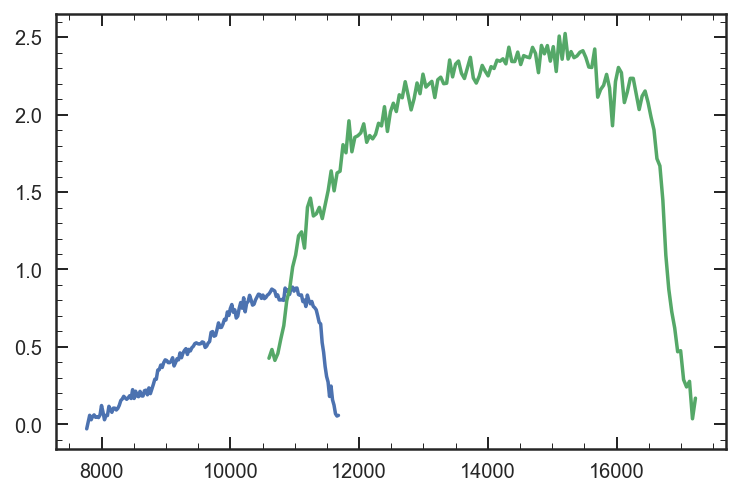

In [80]:
plt.plot(B[0],B[1])
plt.plot(R[0],R[1])


In [92]:
beam_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*40597*beams.fits')

In [101]:
fields = [U.split('/')[4] for U in beam_list]

In [103]:
flt_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0]))

In [119]:
# grp = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0])))
# grp2 = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[1])))
grp = 0;grp2= 0

In [117]:
ex = Extract_all(40597,'GSD',[grp,grp2])

In [118]:
ex.Phot_save()
ex.Extract_spec()
ex.Extract_BeamCutout()

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in power
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


In [3]:
gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],tmp_err=False)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


<ErrorbarContainer object of 3 artists>

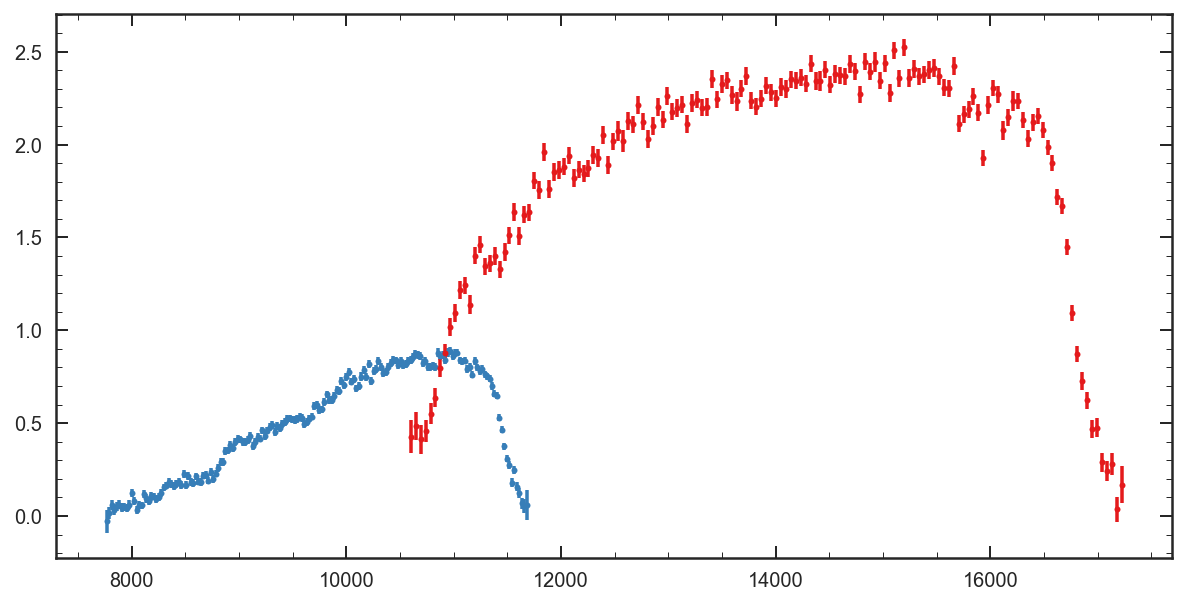

In [4]:
plt.figure(figsize=[10,5])
plt.errorbar(gs.Bwv,gs.Bflx,gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(gs.Rwv,gs.Rflx,gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

In [348]:
def Set_params(metal_i, age_i, tau_i, rshift_i, dust_i, stage):
    if stage == 0:
        age = np.round(np.arange(0.5, 6.1, .25),2)
        metal= np.round(np.arange(0.002 , 0.031, 0.003),4)
        tau = np.round(np.logspace(np.log10(0.01), np.log10(3), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.01, rshift_i + 0.011, 0.002),4)
        dust = np.round(np.arange(0, 1.1, 0.1),2)
    
    if stage == 1:
        if age_i <=1.5:
            age_i = 1.6
        age = np.round(np.arange(age_i  - 1.5, age_i  + 1.6, .125),2)
        
        if metal_i <= 0.0075:
            metal_i = 0.0095
        metal= np.round(np.arange(metal_i  - 0.0075, metal_i  + 0.0085, 0.0015),4)
        
        if tau_i <= 1:
            tau_i = 1.1 
        tau = np.round(np.logspace(np.log10(tau_i  - 1), np.log10(tau_i  + 1), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.005, rshift_i + 0.006, 0.001),4)
        
        if dust_i <= 0.25:
            dust_i = 0.25         
        dust = np.round(np.arange(dust_i - 0.25, dust_i + 0.3, 0.05),2)
    
    if stage == 2:
        if age_i <= 0.75:
            age_i = 0.85
        age = np.round(np.arange(age_i  - 0.75, age_i  + 0.85, .06),2)
        
        if metal_i <= 0.00375:
            metal_i = 0.00575
        metal= np.round(np.arange(metal_i  - 0.00375, metal_i  + 0.00475, 0.00075),4)
                
        if tau_i <= 0.5:
            tau_i = 0.51   
        tau = np.round(np.logspace(np.log10(tau_i  - 0.5), np.log10(tau_i  + 0.5), 8), 3)
        rshift = np.round(np.arange( rshift_i - 0.0025, rshift_i + 0.003, 0.0005),4)
        
        if dust_i <= 0.125:
            dust_i = 0.125    
        dust = np.round(np.arange(dust_i - 0.125, dust_i + 0.135, 0.025),3)
    
    return metal, age, tau, rshift, dust

In [349]:
m0,a0,t0,z0,d0=Set_params(0.017, 2.0, 0.1, 1.6, 0., 0)
m1,a1,t1,z1,d1=Set_params(0.023, 1.75, 0.051, 1.221, 0.0, 1)
m2,a2,t2,z2,d2=Set_params(0.017, 2.0, 0.1, 1.6, 0., 2)

print(len(m0)*len(a0)*len(t0)*len(z0)*len(d0))
print(len(m1)*len(a1)*len(t1)*len(z1)*len(d1))
print(len(m2)*len(a2)*len(t2)*len(z2)*len(d2))

222640
266200
313632


In [350]:
print(d0,len(d0))
print(d1,len(d1))
print(d2,len(d2))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] 11
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ] 11
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ] 11


In [36]:
tau = np.round(np.logspace(-2,np.log10(3),20),3)
age = np.round(np.arange(0.1, np.round(Oldest_galaxy(1.221),1) + .05,.05),2)
metal=np.round(np.arange(0.002 , 0.0305, 0.0005),4)

In [7]:
print(len(metal)*len(age)*len(tau))

90060


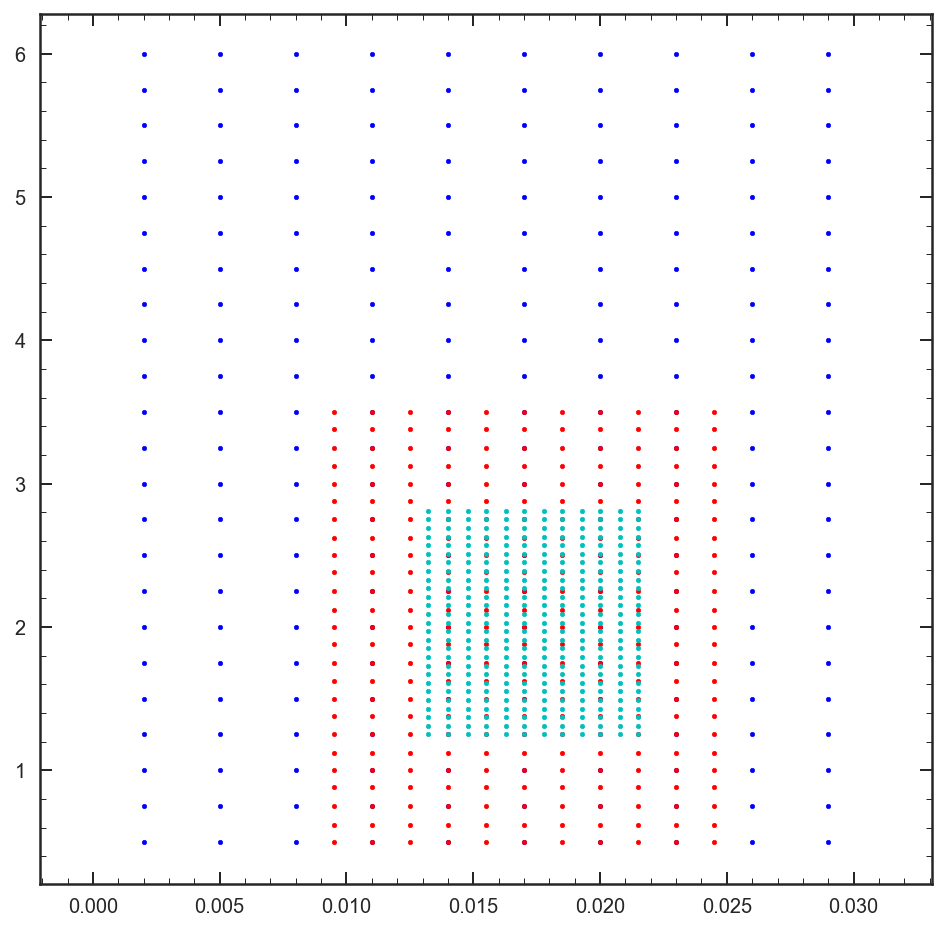

In [321]:
# x=[]
# y=[]
# plt.figure(figsize=[8,8])
# for i in metal:
#     for ii in age:
#         x.append(i)
#         y.append(ii)
plt.figure(figsize=[8,8])
# plt.scatter(x,y,color='k',s=1)

x=[]
y=[]
for i in m0:
    for ii in a0:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='b',s=5)

x=[]
y=[]
for i in m1:
    for ii in a1:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='r',s=5)

x=[]
y=[]
for i in m2:
    for ii in a2:
        x.append(i)
        y.append(ii)
        
plt.scatter(x,y,color='c',s=5)

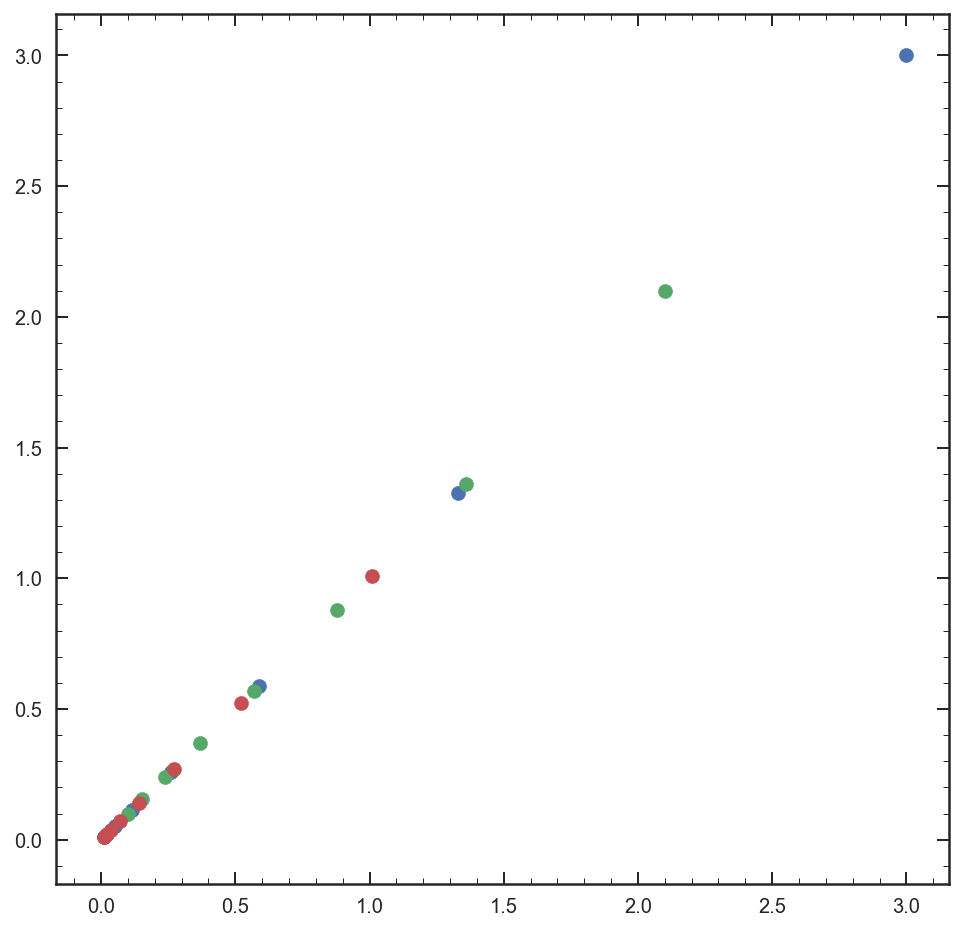

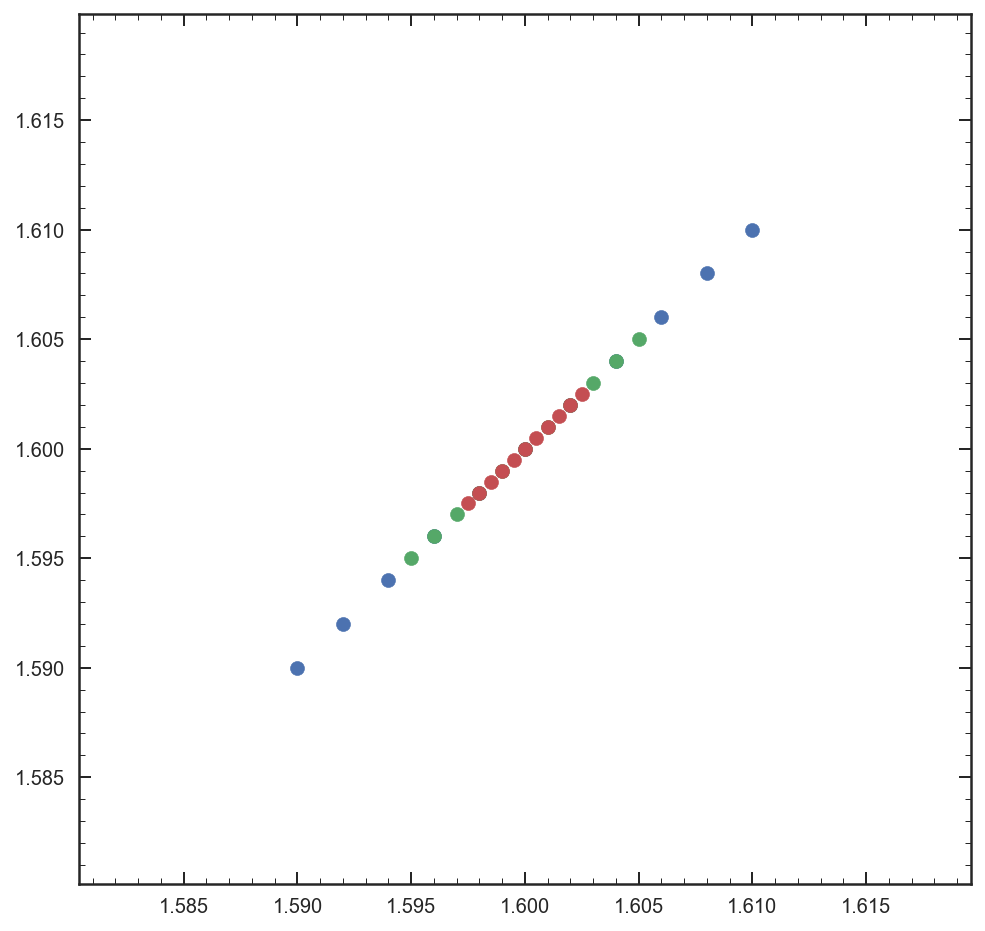

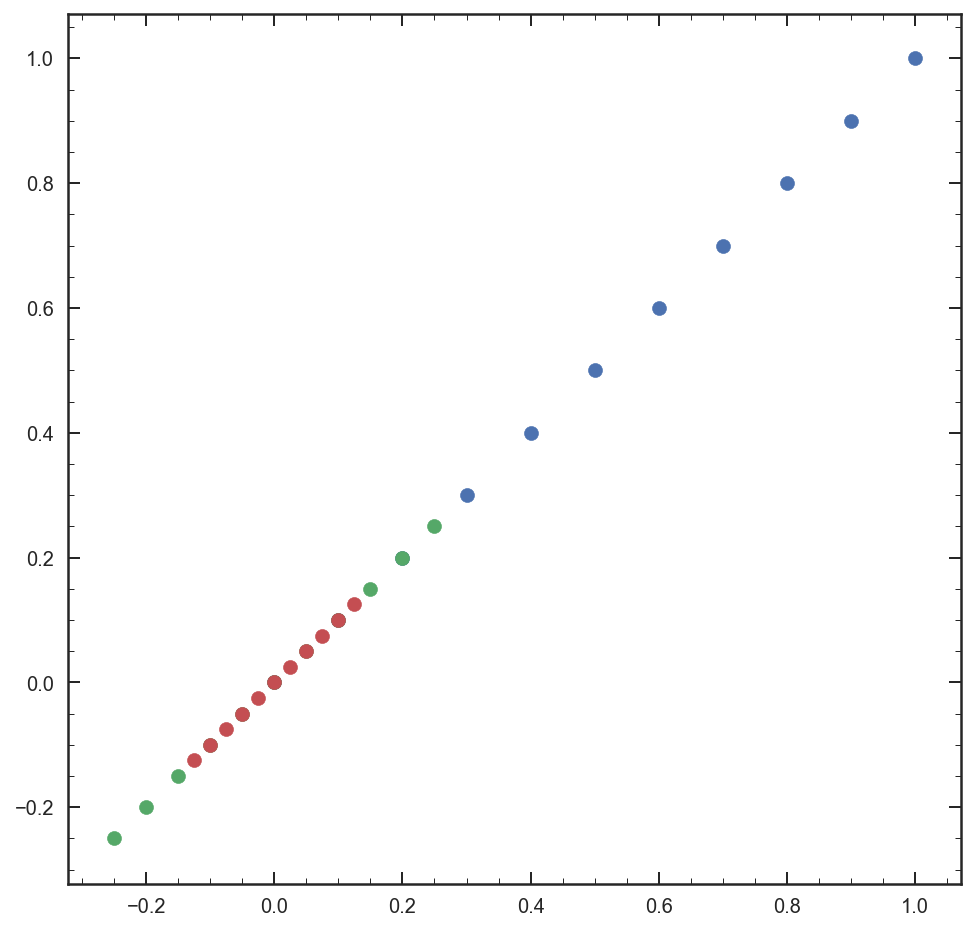

In [329]:
plt.figure(figsize=[8,8])
plt.scatter(t0,t0)
plt.scatter(t1,t1)
plt.scatter(t2,t2)

plt.figure(figsize=[8,8])
plt.scatter(z0,z0)
plt.scatter(z1,z1)
plt.scatter(z2,z2)

plt.figure(figsize=[8,8])
plt.scatter(d0,d0)
plt.scatter(d1,d1)
plt.scatter(d2,d2)

In [106]:
def Gen_mflgrid(spec, models, metal, age, specz):
    wv,fl = models.get_spectrum(tage = 2.0, peraa = True)
    [Bmwv,Bmf_len], [Rmwv,Rmf_len] = spec.Sim_spec_mult(wv,fl)
    
    ##### set model wave
    
    Bmfl = np.zeros([len(metal)*len(age),len(Bmf_len)])
    Rmfl = np.zeros([len(metal)*len(age),len(Rmf_len)])
    Pmfl = np.zeros([len(metal)*len(age),len(spec.IDP)])
    
    for i in range(len(metal)):
        models.params['logzsol'] = np.log10(metal[i] / 0.019)
        for ii in range(len(age)):
            wv,fl = models.get_spectrum(tage = age[ii], peraa = True)
            [Bmwv,Bmflx], [Rmwv,Rmflx] = spec.Sim_spec_mult(wv * (1 + specz),fl)
            Pmflx = spec.Sim_phot_mult(wv * (1 + specz),fl)

            Bmfl[i*len(age) + ii] = Bmflx
            Rmfl[i*len(age) + ii] = Rmflx
            Pmfl[i*len(age) + ii] = Pmflx
    
    return Bmfl, Rmfl, Pmfl

def Stitch_resize_redden_fit(fit_wv, fit_fl, fit_er, mfl, mwv, 
                     metal, age, PC = 0, phot=False):
    #############Read in spectra and stich spectra grid together#################
    if phot:
        PC, chigrid,flgrid = Redden_and_fit(fit_wv, fit_fl, fit_er, mfl, metal, age, phot = True)  
        return PC, chigrid,flgrid
    else:
        mfl = Resize(fit_wv, mwv, mfl)
        chigrid,flgrid = Redden_and_fit(fit_wv, fit_fl, fit_er, mfl, metal, age, PC)  
        return chigrid,flgrid
        
def Redden_and_fit(fit_wv, fit_fl, fit_er, mfl, metal, age, PC = 0, phot = False):    
    scales = []
    chigrids = []
    
    if phot:
        SCL = Scale_model_mult(fit_fl,fit_er,mfl)
        redflgrid = np.array([SCL]).T*mfl
        chigrid = np.sum(((fit_fl - redflgrid) / fit_er) ** 2, axis=1).reshape([len(metal), len(age)])

        scales.append(np.array([SCL]).T)
        chigrids.append(chigrid)
            
        return np.array(np.array([SCL]).T), np.array(chigrid) , redflgrid

    else:
        redflgrid = PC*mfl
        SCL2 = Scale_model_mult(fit_fl,fit_er,redflgrid)
        chigrid = np.sum(((fit_fl / np.array([SCL2]).T - redflgrid) / (fit_er / np.array([SCL2]).T)) ** 2, axis=1).reshape([len(metal), len(age)])

        return np.array(chigrid), redflgrid

def Resize(fit_wv, mwv, mfl):
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp2d(mwv,range(len(mfl.data)),mfl.data)(fit_wv,range(len(mfl.data)))
    return mfl

def Best_fit_model(chi, metal, age):
    x = np.argwhere(chi == np.min(chi))[0]
    return metal[x[0]], age[x[1]]


sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.3)
# wave, flux = sp.get_spectrum(tage = 2.0, peraa = True)
   
# gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
#               g102_lims=[7500,12000],g141_lims=[10000,18000],tmp_err=False, phot_errterm=0.03)  

In [332]:


metal_i = 0.019
age_i = 2
tau_i = 0.1
rshift_i = 1.221
dust_i = 0.1

for x in range(3):

    m, a, t, z, d = Set_params(metal_i, age_i, tau_i, rshift_i, dust_i, x)

    Bmfl, Rmfl, Pmfl = Gen_mflgrid(gs, sp, m, a, 1.221)

    ## set some variables
    [Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave, flux)

    PC, Pgrid,Pmfl = Stitch_resize_redden_fit(gs.Pwv, gs.Pflx, gs.Perr, Pmfl, gs.Pwv, 
                     m, a, phot = True) 
    Bgrid,Bmfl = Stitch_resize_redden_fit(gs.Bwv, gs.Bflx, gs.Berr, Bmfl, Bmwv, 
                     m, a, PC)
    Rgrid,Rmfl = Stitch_resize_redden_fit(gs.Rwv, gs.Rflx, gs.Rerr, Rmfl, Rmwv, 
                     m, a, PC)
    
    bfZ, bft = Best_fit_model(Pgrid + Bgrid +Rgrid, m, a)
        
    metal_i = bfZ
    age_i = bft
    
    print(metal_i,age_i)

0.023 1.75
0.0245 1.75
0.0238 1.78


In [52]:
xBmfl, xRmfl, xPmfl = Gen_mflgrid(gs, sp, metal, age, 1.221)

## set some variables
[Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave, flux)

xPC, xPgrid, xPmfl = Stitch_resize_redden_fit(gs.Pwv, gs.Pflx, gs.Perr, xPmfl, gs.Pwv, 
                 metal, age, phot = True) 
xBgrid, xBmfl = Stitch_resize_redden_fit(gs.Bwv, gs.Bflx, gs.Berr, xBmfl, Bmwv, 
                 metal, age, xPC)
xRgrid, xRmfl = Stitch_resize_redden_fit(gs.Rwv, gs.Rflx, gs.Rerr, xRmfl, Rmwv, 
                 metal, age, xPC)

In [53]:
# Tgrid = np.array(Bgrid+Rgrid+Pgrid).astype(np.float128)
xTgrid = np.array(xBgrid+xRgrid+xPgrid).astype(np.float128)

In [54]:
def Prob(grid,metal,age):
    P = np.exp(-grid.T/2)
    return P/ np.trapz(np.trapz(P,metal,axis=1),age)

In [55]:
# PB = Prob(Bgrid,m,a)
# PR = Prob(Rgrid,m,a)
# PP = Prob(Pgrid,m,a)
# PT = Prob(Tgrid,m,a)

xPB = Prob(xBgrid,metal,age)
xPR = Prob(xRgrid,metal,age)
xPP = Prob(xPgrid,metal,age)
xPT = Prob(xTgrid,metal,age)

In [59]:
# print(Best_fit_model(Bgrid,m,a),Best_fit_model(Rgrid,m,a),Best_fit_model(Pgrid,m,a),
# Best_fit_model(Tgrid,m,a))

print(Best_fit_model(xBgrid,metal,age),Best_fit_model(xRgrid,metal,age),Best_fit_model(xPgrid,metal,age),
Best_fit_model(xTgrid,metal,age))

(0.005, 2.5) (0.012, 1.25) (0.0105, 5.1) (0.0245, 1.6)


In [57]:
M,A=np.meshgrid(m,a)
plt.figure(figsize=[6,6])
plt.contourf(M,A,PB)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PR)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PP)

plt.figure(figsize=[6,6])
plt.contourf(M,A,PT)
plt.scatter(0.0215,1.54,color='b')
plt.scatter(0.0283,1.48,color='r')
plt.scatter(0.0208,2.56,color='c')
plt.scatter(0.0238,1.78,color='k')

NameError: name 'm' is not defined

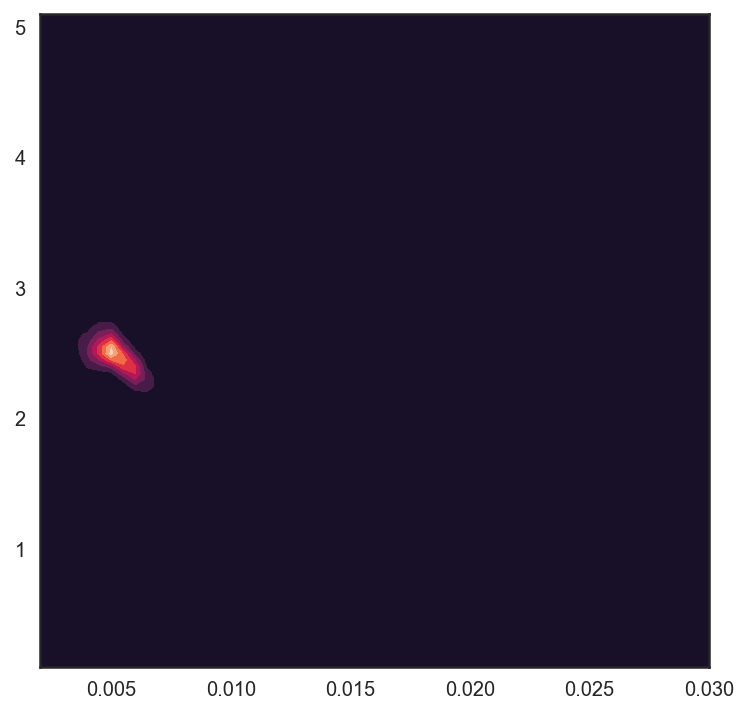

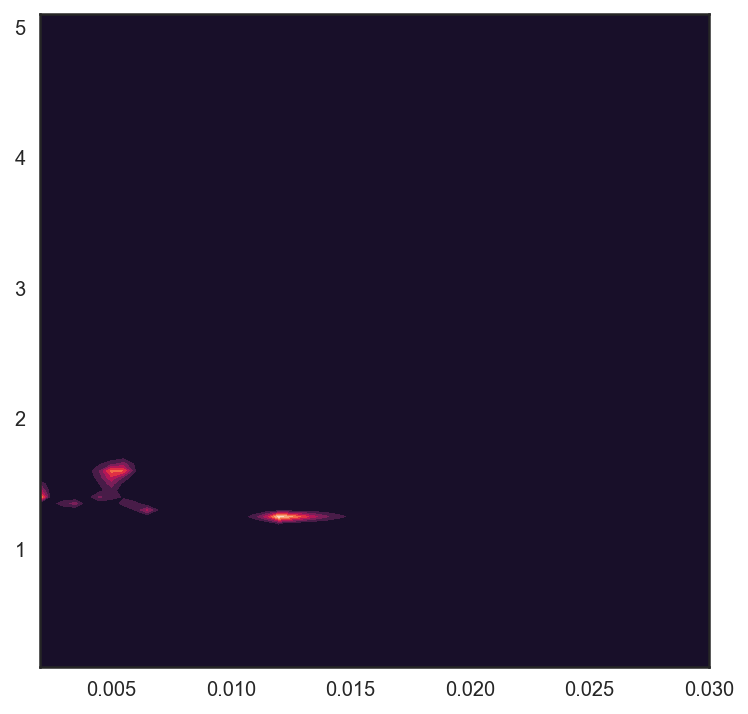

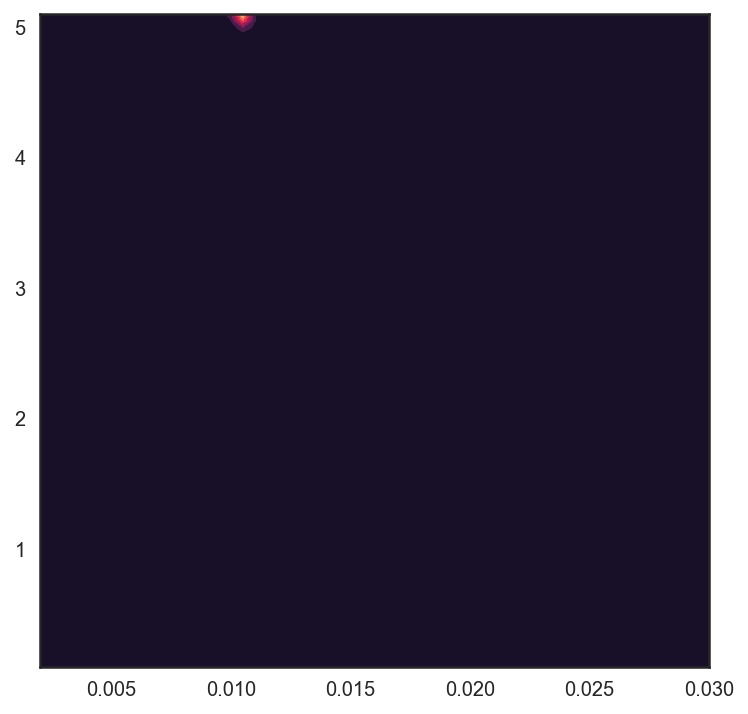

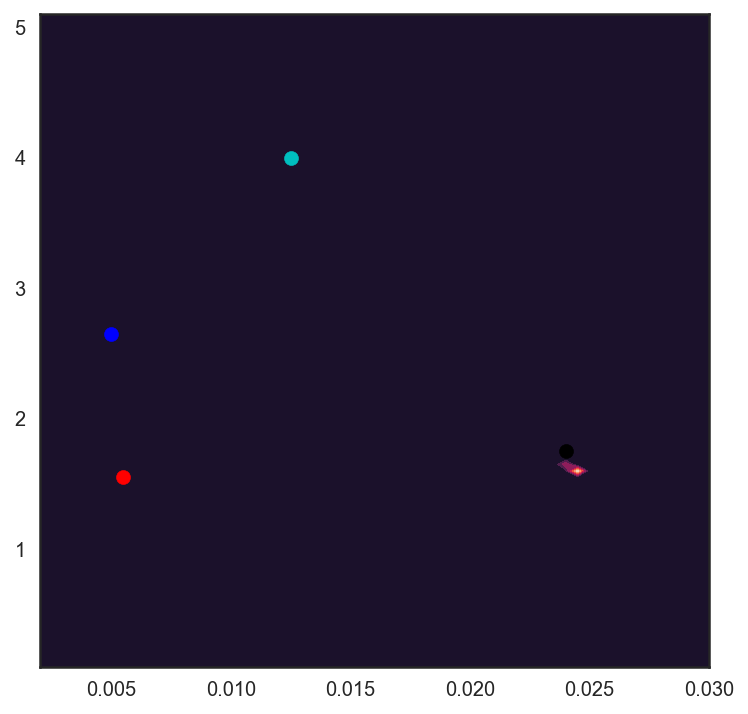

In [58]:
M,A=np.meshgrid(metal,age)
plt.figure(figsize=[6,6])
plt.contourf(M,A,xPB)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPR)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPP)

plt.figure(figsize=[6,6])
plt.contourf(M,A,xPT)
plt.scatter(0.005,2.65,color='b')
plt.scatter(0.0055,1.55,color='r')
plt.scatter(0.0125,4.0,color='c')
plt.scatter(0.024,1.75,color='k')
# (0.005, 2.65) (0.0055, 1.55) (0.0125, 4.0) (0.024, 1.75)


In [23]:
wave, flux = gs.sp.get_spectrum(tage=5.0, peraa=True)

[Bmwv,Bmflx], [Rmwv,Rmflx] = gs.Sim_spec_mult(wave*2.231, flux)
Pmflx = gs.Sim_phot_mult(wave*2.231, flux)

Bmfl = interp1d(Bmwv,Bmflx)(gs.Bwv)
Rmfl = interp1d(Rmwv,Rmflx)(gs.Rwv)

(3, 5)

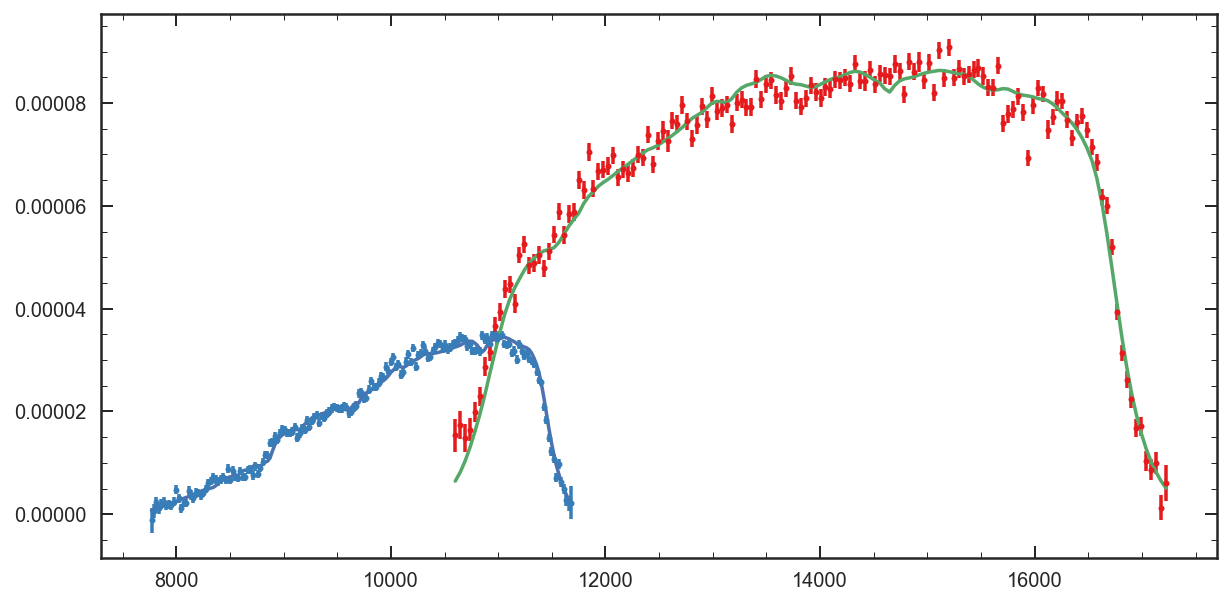

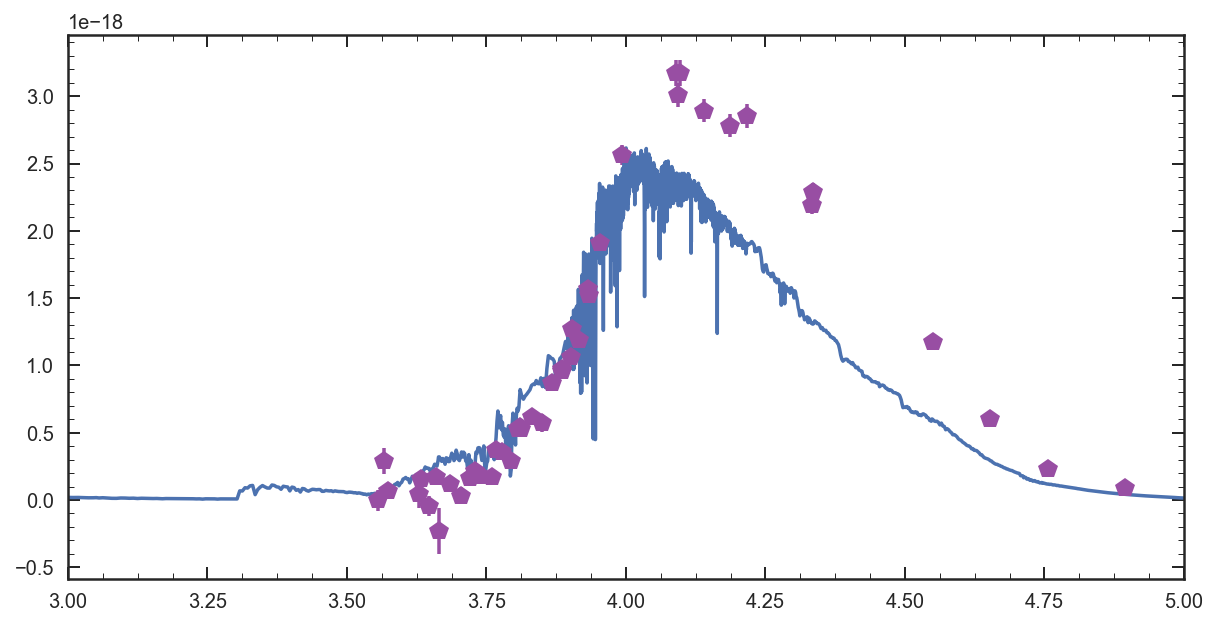

In [24]:
Cb=Scale_model(gs.Bflx,gs.Berr,Bmfl)
Cr=Scale_model(gs.Rflx,gs.Rerr,Rmfl)
Cp=Scale_model(gs.Pflx,gs.Perr,Pmflx)

plt.figure(figsize=[10,5])
plt.errorbar(gs.Bwv,gs.Bflx/Cb,gs.Berr/Cb,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(gs.Bwv,Bmfl)
plt.errorbar(gs.Rwv,gs.Rflx/Cr,gs.Rerr/Cr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(gs.Rwv,Rmfl)

plt.figure(figsize=[10,5])
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(wave*2.221), Cp*flux)
plt.xlim(3,5)

In [80]:
gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],
              tmp_err=False, phot_errterm=0.03)  


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [81]:
gs.Sim_all(0.003, 5.05, 0.149, 1.221, 0.4)


(-1e-18, 4e-18)

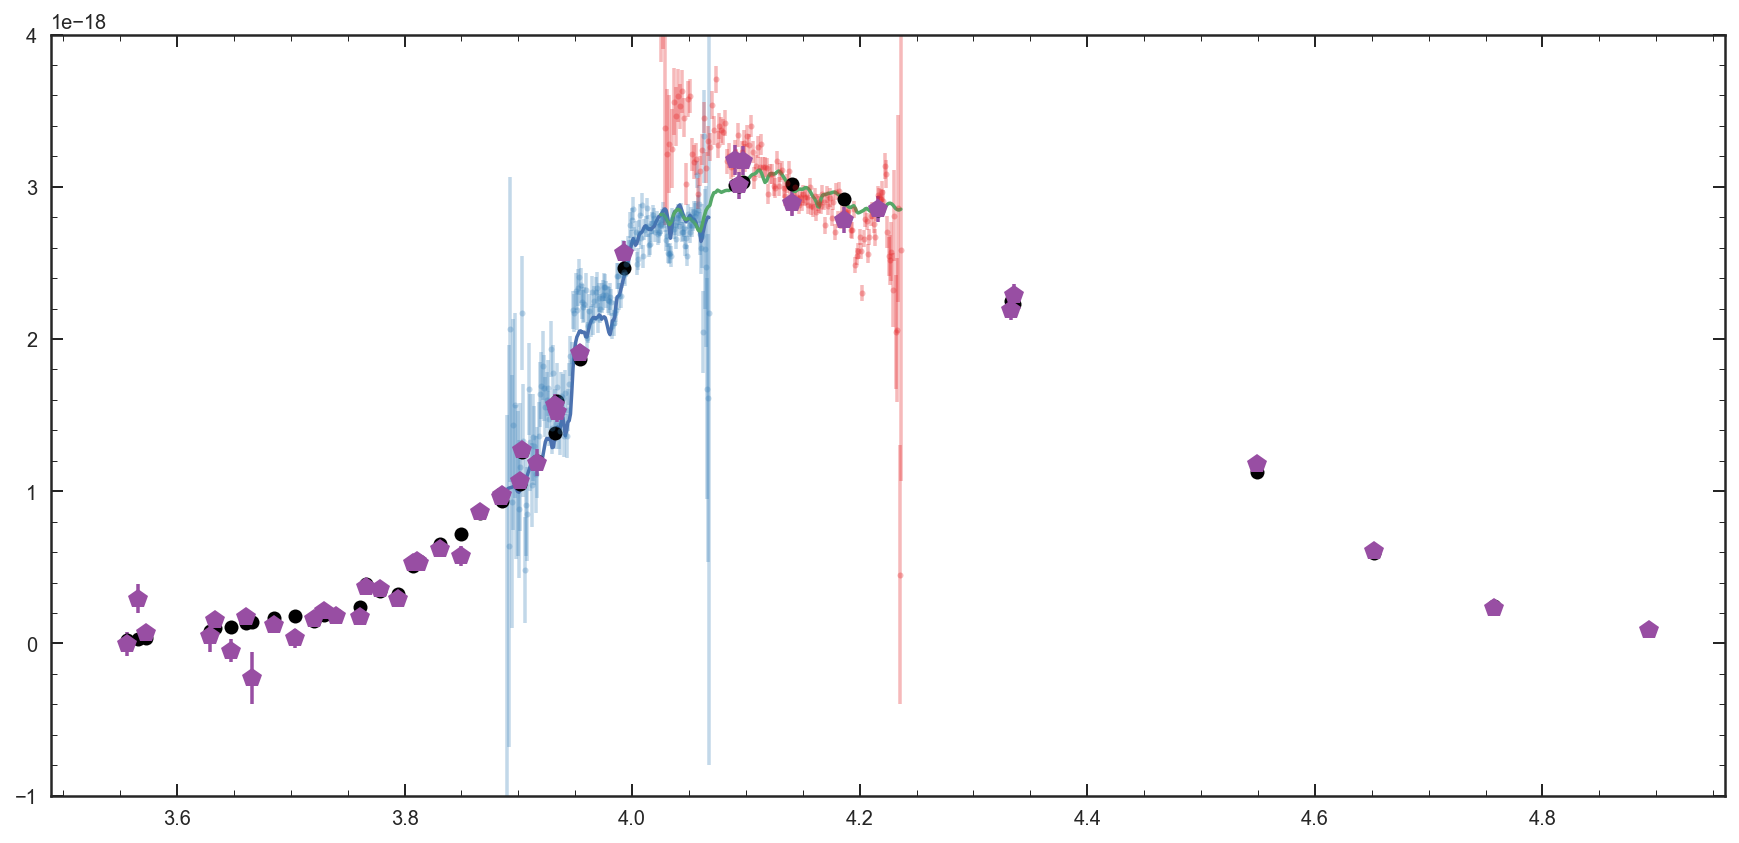

In [82]:
plt.figure(figsize=[15,7])

plt.errorbar(np.log10(gs.Bwv), gs.Bfl, gs.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.plot(np.log10(gs.Bwv), gs.Bmfl)
plt.errorbar(np.log10(gs.Rwv), gs.Rfl, gs.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)
plt.plot(np.log10(gs.Rwv), gs.Rmfl)
plt.errorbar(np.log10(gs.Pwv), gs.Pflx, gs.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(gs.Pwv), gs.Pmfl,'ko')

plt.ylim(-1E-18,4E-18)

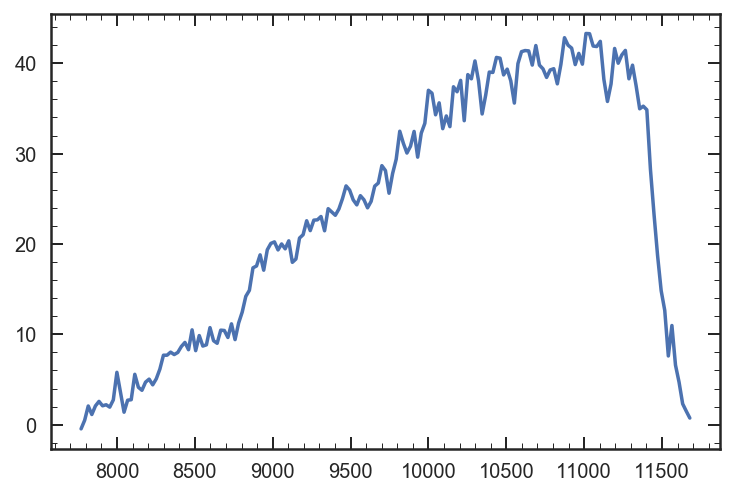

In [30]:
plt.plot(gs.Bwv, gs.Bflx / gs.Berr)

In [107]:
tau = np.round(np.logspace(-2,np.log10(3),20),3)
age = np.round(np.arange(0.1, np.round(Oldest_galaxy(1.221),1) + .05,.05),2)
metal=np.round(np.arange(0.002 , 0.0305, 0.0005),4)
dust = np.arange(0, 1.05, 0.05)
Tchi = 1E5

# for i in range(len(metal)):
#     sp.params['logzsol'] = np.log10(metal[i] / 0.019)
#     for ii in range(len(tau)):
#         sp.params['tau'] = tau[ii]
#         for iii in range(len(age)):
#             wvc, flc = sp.get_spectrum(tage = age[iii], peraa = True)
#             for iv in range(len(dust)):
#                 Pmfl=gs.Sim_phot_mult(wvc*(1 + 1.221),flc * Salmon(dust[iv],wvc))
#                 C = Scale_model(gs.Pflx, gs.Perr, Pmfl)

#                 Pchi = Chi_Squared(gs.Pflx, Pmfl*C, gs.Perr)

#                 if Pchi < Tchi:
#                     Tchi = Pchi
#                     print(metal[i], age[iii], tau[ii], dust[iv], Tchi)

chi = np.zeros([len(metal),len(age)])

for i in range(len(metal)):
    sp.params['logzsol'] = np.log10(metal[i] / 0.019)
    for ii in range(len(age)):
        wvc, flc = sp.get_spectrum(tage = age[ii], peraa = True)
        Pmfl=gs.Sim_phot_mult(wvc*(1 + 1.221),flc)
        C = Scale_model(gs.Pflx, gs.Perr, Pmfl)
        Pchi = Chi_Squared(gs.Pflx, Pmfl*C, gs.Perr)
        chi[i][ii] = Pchi

In [108]:
trim = np.array(chi.T)
trim[trim > 400] = 0

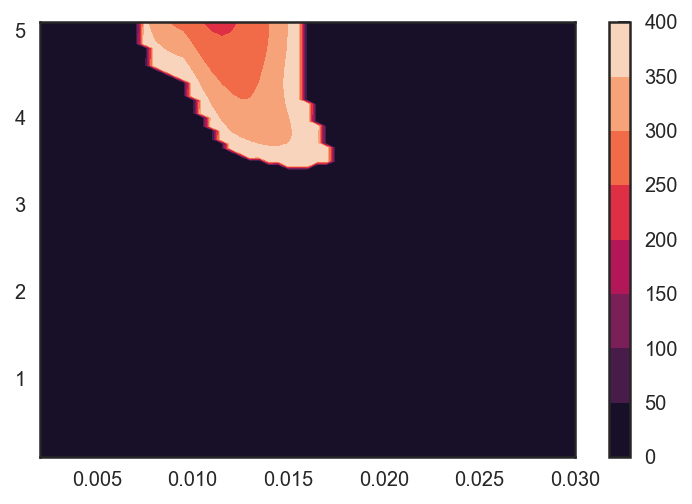

In [109]:
plt.contourf(M,A,trim)
plt.colorbar()

In [100]:
chi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])